In [1]:
import os
import pickle
import time

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch import nn

In [2]:
#
# Execution parameters
#_

CONFIG={
"DATASETS_PATH":"preprocessed_datasets/",               # folder where the dataset is read from
"DATASET_NAME":"coronavirus_2021q1_all_preprocessed",   # dataset name
"BATCH_SIZE":2**14,                                     # batch size
"SPLIT_METHOD":"valid_both",                            # how to form the test set. options: "random", "valid_users", "valid_subreddits", "valid_both", "controlled_users"
"MODEL":"toxicity_BERT_simple",                         # model architecture: "toxicity_simple", "toxicity_NCF", "toxicity_BOW", "toxicity_BERT_simple"
"DROP_UNTESTED_USERS": True,                            # not include in train set those users or subreddits that aren't used in the test set
"TRAIN_WITH_GPU": True,                                 # to train with GPU, whould always be true
"BALANCE_TRAIN_USERS": "user",                          # underampling method of train test: "none", "user", "global". "user" performs balancing PER USER
"USE_BIAS": True,                                       # whether to include bias embeddings in the model 
"EMBEDDING_SIDE": None,                                 # set to "user" or "subreddit" on toxicity_BERT_simple to replace that "leg" of the model with a simple n_users->d embedding
"MAX_IMBALANCE_RATIO":2,                              # used with balance_train_users "user" option to allow a max imbalance of x:1 ratio
"BERT_MODEL":"MARCH_21_toxic"                           # select the BERT embeddings set to use for toxicity_BERT_simple
}

# Grid search parameters

GRIDSEARCH_PARAMS={
"learning_rates":[1e-2,5e-4,1e-5],      # learning rates
"n_factors":[32,128,512],               # size d of latent space
"l2_regs":[1e-2,1e-4,0]                 # L2 regularizations
}

epochs=200

device = torch.device("cuda" if torch.cuda.is_available() and CONFIG['TRAIN_WITH_GPU'] else "cpu")

In [3]:
#
# Read dataset and obtain the basic model inputs and outputs
#

df=pd.read_csv(f'{CONFIG["DATASETS_PATH"]}/{CONFIG["DATASET_NAME"]}_preprocessed_toxicity.csv',encoding='UTF_8')

#We roughly defined a (user,subreddit) interaction as toxic when the mean toxicity is >0
df["Toxicity"]=torch.sigmoid(torch.Tensor(df["Toxicity"]))
df=df.groupby(['author_id','subreddit_id'],as_index=False)['Toxicity'].mean()
df['Toxicity']=df['Toxicity'].apply(lambda x: round(x))

print(f"Toxic interactions: {(100*(df['Toxicity'].sum()/len(df['Toxicity']))):.2f}%") #Percentage of toxic interactions (not comments!)

#Primary inputs (author_id, subreddit_id) and outputs (toxicity)
x=df.drop(['Toxicity'],axis=1).to_numpy().astype(int)
y=df['Toxicity'].to_numpy()



n_users=df['author_id'].nunique()
n_subreddits=df['subreddit_id'].nunique()

Toxic interactions: 9.66%


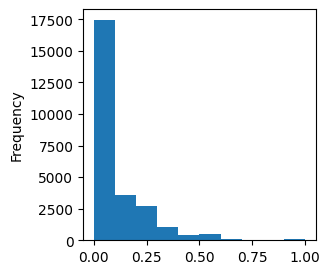

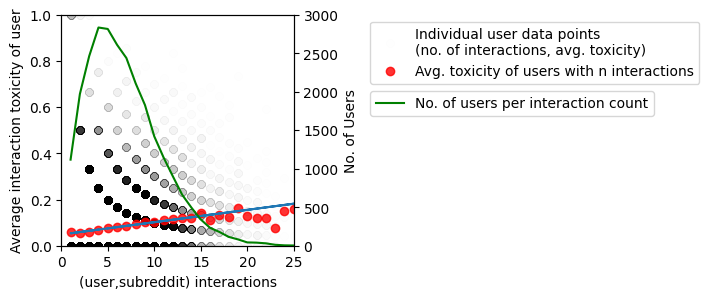

In [4]:
#
# Data analysis and plots
#

plt.rcParams["figure.figsize"]=(3,3)

#Plot histogram of Avg. Toxicity per user
avg_toxicity_per_user=df.groupby(['author_id'],as_index=False)['Toxicity'].mean()
avg_toxicity_per_user['Toxicity'].plot.hist()
plt.show()

#Obtain dataframe with (user_id,comment_count,mean_toxicity)
no_comments_per_user=df.groupby(['author_id'],as_index=False).size()
no_comments_per_user["mean_toxicity"]=avg_toxicity_per_user["Toxicity"]

#** Obtain dataframe with (number_of_comments, avg toxicity for users with number_of_comments)
avg_toxicity_per_interaction_count=no_comments_per_user.groupby(['size'],as_index=False)['mean_toxicity'].mean()

#Obtain dataframe with (number_of_comments, number of users with number_of_comments comments)
no_users_per_comment_count=no_comments_per_user.rename(columns={'size':'comment_count'}).groupby(['comment_count'],as_index=False).size()

#Obtain regression for **
m, b = np.polyfit(no_comments_per_user["size"].to_numpy(), avg_toxicity_per_user['Toxicity'].to_numpy(), 1)

#Plot everything:

#Left y-axis
plt.plot(no_comments_per_user["size"].to_numpy(), avg_toxicity_per_user['Toxicity'].to_numpy(), 'o', alpha=0.005, c='black',label="Individual user data points\n(no. of interactions, avg. toxicity)")
plt.plot(avg_toxicity_per_interaction_count["size"].to_numpy(), avg_toxicity_per_interaction_count['mean_toxicity'].to_numpy(), 'o', alpha=.8, c='red', label="Avg. toxicity of users with n interactions")
plt.plot(no_comments_per_user["size"].to_numpy(), m*no_comments_per_user["size"].to_numpy() + b)

plt.ylim((0,1))
plt.xlim((0,25))

plt.xlabel("(user,subreddit) interactions")
plt.ylabel("Average interaction toxicity of user")

plt.legend(bbox_to_anchor=(1.3, 1), loc="upper left")

#Switch axis
plt.twinx()

#Right y-axis
plt.plot(no_users_per_comment_count["comment_count"].to_numpy(),no_users_per_comment_count["size"].to_numpy(),color='green',label="No. of users per interaction count")

plt.ylim((0,3000))

plt.ylabel("No. of Users")

plt.legend(bbox_to_anchor=(1.3, 0.7), loc="upper left")

plt.show()

In [5]:

#Split train and test sets
from toxicity_utils import train_test_split

train,test=train_test_split(df,method=CONFIG['SPLIT_METHOD'],balance_train=CONFIG['BALANCE_TRAIN_USERS'],drop_untested_users=CONFIG['DROP_UNTESTED_USERS'],max_imbalance_ratio=CONFIG["MAX_IMBALANCE_RATIO"]) 

toxic_labels_weight=(len(train['Toxicity'])-train['Toxicity'].sum())/train['Toxicity'].sum()
print(f"Applying a weight of {toxic_labels_weight:.2f} for positive samples in training loss")

X_train=train.drop(['Toxicity'],axis=1).to_numpy().astype(int)
X_test=test.drop(['Toxicity'],axis=1).to_numpy().astype(int)

y_train=train['Toxicity'].to_numpy()
y_test=test['Toxicity'].to_numpy()

X_train, X_test = torch.Tensor(X_train).int().to(device), torch.Tensor(X_test).int().to(device)
y_train, y_test = torch.Tensor(y_train).float().to(device), torch.Tensor(y_test).float().to(device)

Found 1184 users  and 262 that meet criteria
Intersecting these users and subreddits, 1184 and 257 are preserved
Total test samples: 2368
Applying a weight of 1.36 for positive samples in training loss


In [6]:
#
# Load additional data depending on architecture
#


if CONFIG['MODEL']=="toxicity_BOW":

    #Load users' and subreddits' Bag of Words
    user_bows=pickle.load(open("preprocessed_datasets/coronavirus_2021q1_all_preprocessed_USERS_BAG_OF_WORDS","rb"))
    subreddit_bows=pickle.load(open("preprocessed_datasets/coronavirus_2021q1_all_preprocessed_SUBREDDIT_BAG_OF_WORDS","rb"))

    #We're gonna work with binary vectors for now
    user_bows[user_bows>1]=1
    subreddit_bows[subreddit_bows>1]=1

    user_bows=torch.Tensor(user_bows).float().to(device)
    subreddit_bows=torch.Tensor(subreddit_bows).float().to(device)

if CONFIG['MODEL'] in ["toxicity_BERT_simple"]:
    
    df_raw=pd.read_csv(f"{CONFIG['DATASETS_PATH']}/{CONFIG['DATASET_NAME']}_preprocessed_toxicity.csv",encoding='UTF_8')

    df_raw = df_raw[~(df_raw[['author_id','subreddit_id']].apply(tuple,axis=1).isin(test[['author_id','subreddit_id']].apply(tuple,axis=1)))]
    embeddings=pickle.load(open(f"BERT_EMBEDDINGS/{CONFIG['BERT_MODEL']}",'rb'))

    commentlists_user=df_raw.groupby('author_id')['comment_id'].apply(list).reset_index(name="comment_ids")
    bertavg_users=np.stack(commentlists_user["comment_ids"].apply(lambda x: np.average(embeddings[x,:],axis=0)).to_numpy(),axis=0)

    commentlists_subreddit=df_raw.groupby('subreddit_id')['comment_id'].apply(list).reset_index(name="comment_ids")
    bertavg_subreddits=np.stack(commentlists_subreddit["comment_ids"].apply(lambda x: np.average(embeddings[x,:],axis=0)).to_numpy(),axis=0)
    
    bertavg_users=torch.Tensor(bertavg_users).float().to(device)
    bertavg_subreddits=torch.Tensor(bertavg_subreddits).float().to(device)
    

In [7]:
#
# Define the model architecture
#

class ToxicitySimple(nn.Module):
    def __init__(self,d):
        super(ToxicitySimple,self).__init__()

        #We only have one trainable layer depth (two Embeddings and two FC's)
        
        self.u = nn.Embedding(n_users,d)                #Embedding author_id -> n_factors
        self.m = nn.Embedding(n_subreddits,d)           #Embedding subreddit_id-> n_factors

        #Initialize weights
        self.u.weight.data.uniform_(-0.1, 0.1)
        self.m.weight.data.uniform_(-0.1, 0.1)

        if CONFIG["USE_BIAS"]:
            self.u_bias = nn.Embedding(n_users,1)
            self.m_bias = nn.Embedding(n_subreddits,1)

            self.u_bias.weight.data.uniform_(-0.1, 0.1)
            self.m_bias.weight.data.uniform_(-0.1, 0.1)



    def forward(self, x):
        users, subs= x[:,0] , x[:,1]       # User ids, subs ids
        u, m = self.u(users), self.m(subs) # Embed author and subreddit
        dot = (u*m).sum(1)                 # Dot product

        # Add user and subreddit bias
        if CONFIG["USE_BIAS"]:
            u_bias, m_bias = self.u_bias(users), self.m_bias(subs) 
            dot = dot + torch.squeeze(u_bias) + torch.squeeze(m_bias)

        return dot

#References: https://towardsdatascience.com/paper-review-neural-collaborative-filtering-explanation-implementation-ea3e031b7f96
class ToxicityNCF(nn.Module):
    def __init__(self,d):
        super(ToxicityNCF,self).__init__()

        #We only have one trainable layer depth (two Embeddings and two FC's)
        self.u_mf = nn.Embedding(n_users,d)                #Embedding author_id -> n_factors
        self.u_mlp = nn.Embedding(n_users,d)               #Embedding author_id -> n_factors
        self.m_mf = nn.Embedding(n_subreddits,d)           #Embedding subreddit_id-> n_factors
        self.m_mlp = nn.Embedding(n_subreddits,d)          #Embedding subreddit_id-> n_factors

        #Initialize weights
        self.u_mf.weight.data.uniform_(-0.5, 0.5)
        self.u_mlp.weight.data.uniform_(-0.5, 0.5)

        self.m_mf.weight.data.uniform_(-0.5, 0.5)
        self.m_mlp.weight.data.uniform_(-0.5, 0.5)

        self.fc_mf_1 = nn.Linear(d,d//2)
        self.fc_mf_2 = nn.Linear(d//2,d//4)

        self.fc_mf_1.weight.data.uniform_(-0.5, 0.5)
        self.fc_mf_2.weight.data.uniform_(-0.5, 0.5)

        self.fc_mlp_1 = nn.Linear(d*2,d)
        self.fc_mlp_2 = nn.Linear(d,d//2)
        self.fc_mlp_3 = nn.Linear(d//2,d//4)

        self.fc_mlp_1.weight.data.uniform_(-0.5, 0.5)
        self.fc_mlp_2.weight.data.uniform_(-0.5, 0.5)
        self.fc_mlp_3.weight.data.uniform_(-0.5, 0.5)

        self.neumf = nn.Linear(d//2,1)
        self.neumf.weight.data.uniform_(-0.5, 0.5)

        self.dropout=nn.Dropout(0.1)

    def forward(self, x):
        
        users, subreddits = x[:,0] , x[:,1] #Get author_id and subreddit_id from input
        # ubows, sbows = user_bows[x[:,0].long()], subreddit_bows[x[:, 1].long()] #Get author bow and subreddit bow indirectly from input
        u_mf, m_mf = self.u_mf(users), self.m_mf(subreddits) #Embed author and subreddit

        u_mlp, m_mlp = self.u_mlp(users), self.m_mlp(subreddits)

        mf = self.dropout(nn.functional.relu(self.fc_mf_1(u_mf*m_mf)))
        mf = self.dropout(nn.functional.relu(self.fc_mf_2(mf)))

        mlp = self.dropout(nn.functional.relu(self.fc_mlp_1(torch.cat((u_mlp,m_mlp),1))))
        mlp = self.dropout(nn.functional.relu(self.fc_mlp_2(mlp)))
        mlp = self.dropout(nn.functional.relu(self.fc_mlp_3(mlp)))

        neumf = self.neumf(torch.cat((mf,mlp),1))

        return neumf



class ToxicityBERTSimple(nn.Module):
    def __init__(self,d):
        super(ToxicityBERTSimple,self).__init__()

        if CONFIG["EMBEDDING_SIDE"]=="user":
            self.m = nn.Linear(bertavg_subreddits.shape[1],d)  #FC BERT embedding (subreddit average) -> d
            self.u = nn.Embedding(n_users,d)                   #Embedding                   author_id -> n_factors
        elif CONFIG["EMBEDDING_SIDE"]=="subreddit":
            self.u = nn.Linear(bertavg_users.shape[1],d)       #FC BERT embedding (user average) -> d 
            self.m = nn.Embedding(n_subreddits,d)              #Embedding           subreddit_id -> n_factors
        else: 
            self.u = nn.Linear(bertavg_users.shape[1],d)       #FC BERT      embedding (user average) -> d
            self.m = nn.Linear(bertavg_subreddits.shape[1],d)  #FC BERT embedding (subreddit average) -> d
        

        self.fc1 = nn.Linear(2*d, d//2)                        #FC d*2 -> d
        self.fc2 = nn.Linear(d//2, 1)                          #FC d   -> 1


        #Initialize weights
        self.u.weight.data.uniform_(-0.1, 0.1)
        self.m.weight.data.uniform_(-0.1, 0.1)
        self.fc1.weight.data.uniform_(-0.1, 0.1)
        self.fc2.weight.data.uniform_(-0.1, 0.1)

        if CONFIG["USE_BIAS"]:
            self.u_bias = nn.Embedding(n_users,1)
            self.m_bias = nn.Embedding(n_subreddits,1)

            self.u_bias.weight.data.uniform_(-0.1, 0.1)
            self.m_bias.weight.data.uniform_(-0.1, 0.1)



    def forward(self, x):
        users, subs = x[:,0], x[:, 1]  #User ids, subreddit ids
        ubert, sbert = bertavg_users[users.long()], bertavg_subreddits[subs.long()] #BERT embeddings of user and subreddits

        # Obtain the two d-dimensional vectors of latent features
        if CONFIG["EMBEDDING_SIDE"]=="user":
            u1, m1 = self.u(users), self.m(sbert)
        elif CONFIG["EMBEDDING_SIDE"]=="subreddit":
            u1, m1 = self.u(ubert), self.m(subs) 
        else:
            u1, m1 = self.u(ubert), self.m(sbert) 

        # Concatenation and two layers of FC -> ReLU -> Dropout
        conc = torch.cat((u1,m1),1)
        conc = F.dropout(F.relu(conc),0.1)
        conc = F.dropout(F.relu(self.fc1(conc)),0.1)
        conc = self.fc2(conc)

        # Add user and subreddit bias
        if CONFIG["USE_BIAS"]:
            u_bias, m_bias = self.u_bias(users), self.m_bias(subs) 
            conc = conc + m_bias + u_bias

        return conc

In [8]:
#
# Create the Dataset and Dataloader objects for train and test sets
#

from toxicity_utils import get_dataloader


dataloader=get_dataloader(X_train,y_train,CONFIG['BATCH_SIZE'])
test_dataloader=get_dataloader(X_test,y_test,CONFIG['BATCH_SIZE'])


print(f"Toxic interactions (positive samples) in train test: {np.average(y_train.cpu())*100:.2f}%")
print(f"Toxic interactions (positive samples) in test test: {np.average(y_test.cpu())*100:.2f}%")


Toxic interactions (positive samples) in train test: 42.44%
Toxic interactions (positive samples) in test test: 50.00%


In [9]:
#
# Define the training cycle for the model
#
print(f"CUDA availability: {torch.cuda.is_available()}")
print(f"Using pytorch version {torch.__version__}, {torch.version.cuda}")
def train_toxicity_model(n_factors=64,learning_rate=1e-3,l2_reg=1e-5,epochs=10):
    print(f"Current parameters are d:{n_factors} | L.Rate:{learning_rate} | L2 Reg:{l2_reg}")
    
    losses=[]
    losses_test=[]
    accuracies=[]
    accuracies_test=[]
    TPRs=[]
    TPRs_test=[]
    
    Iterations=[]

    #Initialize model
    if CONFIG['MODEL']=="toxicity_simple":
        model = ToxicitySimple(n_factors).to(device)
    elif CONFIG['MODEL']=="toxicity_NCF":
        model = ToxicityNCF(n_factors).to(device)
    elif CONFIG['MODEL']=="toxicity_BERT_simple":
        model = ToxicityBERTSimple(n_factors).to(device)
    #Model configuration
    optimizer=torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2_reg) #Weight_decay acts as L2 regularization apparently

    print("EPOCH\tLOSS_TRAIN\tLOSS_TEST\tACC_TRAIN\tACC_TEST\tTP\tFP\tFN\tTN\tTPR_TRAIN\tTPR_TEST")
    # for epoch in tqdm(range(int(epochs)), desc='Training Epochs'):
    for epoch in range(int(epochs)):

        model.train()

        loss_train=0
        
        fn=0
        fp=0
        tn=0
        tp=0

        #Iterate training over train batches
        for i,(inputs,labels) in enumerate(dataloader):
            optimizer.zero_grad()  # Setting our stored gradients equal to zero
            outputs = torch.squeeze(model(inputs))

            #References: https://stackoverflow.com/questions/71462326/pytorch-bcewithlogitsloss-calculating-pos-weight
            # https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586 (apparently more numerically stable than BCELoss)

            criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([toxic_labels_weight]).to(device))

            loss = criterion(outputs, labels)
            loss_train += loss.item()*inputs.size(0)

            # print(loss)
            
            

            loss.backward()  # Computes the gradient of the given tensor w.r.t. the weights/bias

            optimizer.step()  # Updates weights and biases with the optimizer (Adam)

            #https://discuss.pytorch.org/t/bcewithlogitsloss-and-model-accuracy-calculation/59293
            predicted_train = ((outputs.cpu() > 0.0)).float().detach().numpy()
            
            labels_train = labels.detach().cpu().numpy()


            tp += np.sum(np.logical_and(predicted_train,labels_train))
            tn += np.sum(np.logical_and(np.logical_not(predicted_train),np.logical_not(labels_train)))
            fn += np.sum(np.logical_and(np.logical_not(predicted_train),labels_train))
            fp += np.sum(np.logical_and(predicted_train,np.logical_not(labels_train)))

        TPRs.append(100*tp/(tp+fn))
                
        accuracy = 100 * (tp+tn) / y_train.size(0)
        
        loss_train = loss_train/y_train.size(0)
            
        losses.append(loss_train)
        accuracies.append(accuracy)
    
           
        with torch.no_grad():
            # Compute metrics for test dataset
            model.eval()
            loss_test=0

            fn=0
            fp=0
            tn=0
            tp=0

            for j, (test_inputs, test_labels) in enumerate(test_dataloader):
                
                outputs_test = torch.squeeze(model(test_inputs))

                if CONFIG['SPLIT_METHOD']=="random":
                    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([toxic_labels_weight]).to(device))
                elif CONFIG['SPLIT_METHOD'] in ["controlled_users","controlled_subreddits","controlled_both"]:
                    criterion = torch.nn.BCEWithLogitsLoss()

                loss_test += criterion(outputs_test, test_labels).item()*test_inputs.size(0)

                predicted_test = ((outputs_test.cpu() > 0.0)).detach().numpy()

                labels_test = test_labels.detach().cpu().numpy()

                tp += np.sum(np.logical_and(predicted_test,labels_test))
                tn += np.sum(np.logical_and(np.logical_not(predicted_test),np.logical_not(labels_test)))
                fn += np.sum(np.logical_and(np.logical_not(predicted_test),labels_test))
                fp += np.sum(np.logical_and(predicted_test,np.logical_not(labels_test)))

            accuracy_test = 100 * (tn+tp) / y_test.size(0)

            loss_test = loss_test/y_test.size(0)

            losses_test.append(loss_test)
            accuracies_test.append(accuracy_test)

            # Calculating the loss and accuracy for the train dataset.

            Iterations.append(iter)

            TPRs_test.append(100*tp/(tp+fn))

            # avg_1_train=np.average(torch.squeeze(outputs).cpu()[np.where(labels_train==1)])
            # avg_1_test=np.average(outputs_test[np.where(labels_test==1)])
            
            print(f"{epoch}\t{loss_train:.7f}\t{loss_test:.7f}\t{accuracy:.2f}\t\t{accuracy_test:.2f}\t\t{tp}\t{fp}\t{fn}\t{tn}\t{TPRs[-1]:.2f}\t\t{TPRs_test[-1]:.2f}",end="\r")
    
    print(f"{epoch}\t{loss_train:.7f}\t{loss_test:.7f}\t{accuracy:.2f}\t\t{accuracy_test:.2f}\t\t{tp}\t{fp}\t{fn}\t{tn}\t{TPRs[-1]:.2f}\t{TPRs_test[-1]:.2f}")
    return losses,losses_test,accuracies,accuracies_test, TPRs, TPRs_test



CUDA availability: True
Using pytorch version 1.12.1+cu113, 11.3


DATASETS_PATH = preprocessed_datasets/ 
DATASET_NAME = coronavirus_2021q1_all_preprocessed 
BATCH_SIZE = 16384 
SPLIT_METHOD = valid_both 
MODEL = toxicity_BERT_simple 
DROP_UNTESTED_USERS = True 
TRAIN_WITH_GPU = True 
BALANCE_TRAIN_USERS = user 
USE_BIAS = True 
EMBEDDING_SIDE = None 
MAX_IMBALANCE_RATIO = 1.5 
BERT_MODEL = MARCH_21_toxic 
learning_rates = [0.01, 0.0005, 1e-05] 
n_factors = [32, 128, 512] 
l2_regs = [0.01, 0.0001, 0] 

Current parameters are d:32 | L.Rate:0.01 | L2 Reg:0.01
EPOCH	LOSS_TRAIN	LOSS_TEST	ACC_TRAIN	ACC_TEST	TP	FP	FN	TN	TPR_TRAIN	TPR_TEST
199	0.7801241	0.8058616	60.66		56.17		736	590	448	594	66.07	62.166
Current parameters are d:32 | L.Rate:0.01 | L2 Reg:0.0001
EPOCH	LOSS_TRAIN	LOSS_TEST	ACC_TRAIN	ACC_TEST	TP	FP	FN	TN	TPR_TRAIN	TPR_TEST
199	0.7376892	0.8274524	62.50		56.50		668	514	516	670	66.89	56.422
Current parameters are d:32 | L.Rate:0.01 | L2 Reg:0
EPOCH	LOSS_TRAIN	LOSS_TEST	ACC_TRAIN	ACC_TEST	TP	FP	FN	TN	TPR_TRAIN	TPR_TEST
199	0.7251868	0.8806109	63

KeyboardInterrupt: 

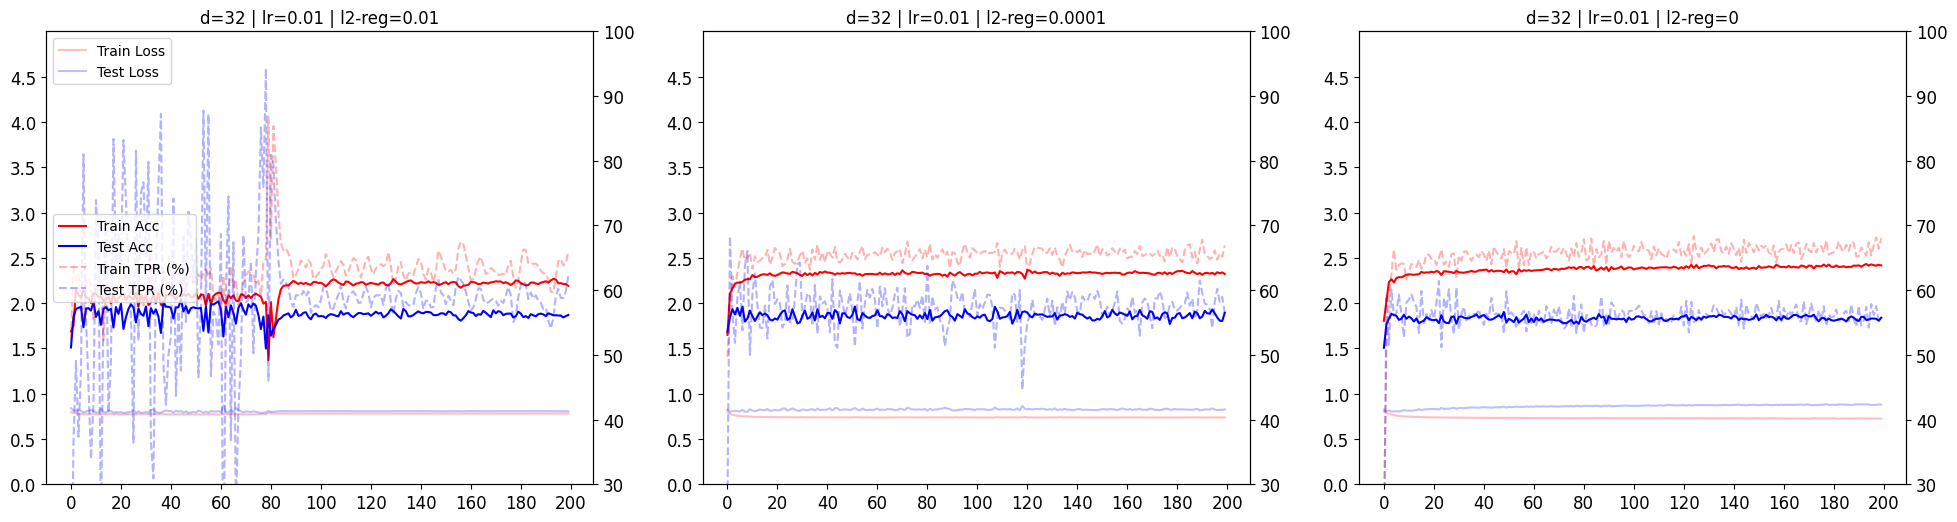

In [10]:
#
# Perform grid search
#

from utils import save_params_file

directory_path = f"grid_search/{time.time()}"
text = save_params_file(directory_path, CONFIG, GRIDSEARCH_PARAMS)
print(text)

# Figures are saved in pdf format in a folder specific to configuration. One figure is created 
# per each *d* used, with one subfigure per each (lr, L2 reg) combination

for d in GRIDSEARCH_PARAMS["n_factors"]:
    i=1

    fig = plt.figure(figsize=(24,(20*min(len(GRIDSEARCH_PARAMS["learning_rates"]),len(GRIDSEARCH_PARAMS["l2_regs"])))/max(len(GRIDSEARCH_PARAMS["learning_rates"]),len(GRIDSEARCH_PARAMS["l2_regs"]))))
    for lr in GRIDSEARCH_PARAMS["learning_rates"]:
        for reg in GRIDSEARCH_PARAMS["l2_regs"]:
            
            losses,losses_test,accuracies,accuracies_test,TPRs,TPRs_test = train_toxicity_model(n_factors=d,learning_rate=lr,l2_reg=reg,epochs=epochs)

            #Plot current training interation:
            plt.subplot(len(GRIDSEARCH_PARAMS["learning_rates"]),len(GRIDSEARCH_PARAMS["l2_regs"]),i)
            plt.title(f"d={d} | lr={lr} | l2-reg={reg}",fontdict={'fontsize': 12})

            plt.xticks(np.arange(0,epochs+1,20),fontsize=12)
            plt.yticks(np.arange(0,5,0.5),fontsize=12)

            plt.ylim(0,5)
            
            plt.plot(np.arange(0,epochs,1),losses, color="red",alpha=.25,label="Train Loss") #Train loss evolution
            plt.plot(np.arange(0,epochs,1),losses_test, color="blue",alpha=.25,label="Test Loss") #Test loss evolution

            if i==1: plt.legend(loc="upper left")

            plt.twinx() #Swap axis

            plt.yticks(np.arange(30,101,10),fontsize=12)

            plt.ylim(30,100)

            plt.plot(np.arange(0,epochs,1),accuracies, color="red", label="Train Acc")         #Train acc evolution
            plt.plot(np.arange(0,epochs,1),accuracies_test, color="blue", label="Test Acc")   #Test acc evolution

            plt.plot(np.arange(0,epochs,1),TPRs, '--', color="red", label="Train TPR (%)" , alpha=.3)   # Train TPR (%) evolution
            plt.plot(np.arange(0,epochs,1),TPRs_test, '--', color="blue", label="Test TPR (%)", alpha=.3)   #Test TPR (%) evolution

            if i==1: plt.legend(loc="center left")
            i+=1

    plt.gcf().text(0.01, 0.95, text, fontsize=12, linespacing=1.5 , verticalalignment='top')
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=5/24)
    plt.savefig(f"{directory_path}/d_{d}.pdf")